In [8]:
from google.colab import drive
drive.mount('/content/drive')

root="/content/drive/MyDrive/signate/ワールドＡＩ/"

import cv2
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import json
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

train_path=root+"train/"
h=1080
w=1920

category={"要補修-1.区画線":0,
 "要補修-2.道路標識":1,
 "要補修-3.照明":2,
 "補修不要-1.区画線":0,
 "補修不要-2.道路標識":1,
 "補修不要-3.照明":2}

yolo_data_path=root+"yolov7/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# yoloデータセット作成

In [ ]:
class make_yolo_data():
    def __init__(self):
        video_files = glob.glob(train_path+"*.mp4")
        base_names=[]
        for file_path in video_files:
            base_name=os.path.basename(file_path)[:-4]
            base_names.append(base_name)
        self.base_names=base_names
    
    def to_yolo_format(self):
        #txtファイルの中身　[base_name][frame_id]
        text_dict={bn:{}for bn in self.base_names}
        for bn in self.base_names:
            #json取得
            with open(f'{train_path}{bn}.json') as f:
                data_list = json.load(f)
            #
            for data in data_list:
                frame_id=data["frame_id"]
                labels=data["labels"]
                text=""
                for k,boxes in labels.items():
                    for box in boxes:
                        box_w,box_h=box[1][0]-box[0][0],box[1][1]-box[0][1]
                        center_x,center_y=int((box[1][0]+box[0][0])/2),int((box[0][1]+box[1][1])/2)
                        text+=f"{category[k]} {center_x/w} {center_y/h} {box_w/w} {box_h/h}\n"
                text_dict[bn][frame_id]=text
                with open(yolo_data_path+f'yolo_data/labels/{bn}_{frame_id}.txt', 'w') as f:
                    f.write(text)
        return True

    def get_yolo_base_names(self):
        video_files = glob.glob(yolo_data_path+"yolo_data/labels/*.txt")
        yolo_base_names=[]
        for file_path in video_files:
            base_name=os.path.basename(file_path)[:-4]
            yolo_base_names.append(base_name)
        self.yolo_base_names=yolo_base_names
        return True

    def video2jpg(self):
        for bn in self.base_names:
            cap = cv2.VideoCapture(train_path+f"{bn}.mp4")
            frame_id = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                else:
                    cv2.imwrite(yolo_data_path+f'yolo_data/images/{bn}_{frame_id}.jpg', frame)
                frame_id += 1
            cap.release()
        return True
    
    def resize_imgs(self,size=(1280,1280)):
        for path in glob.glob(yolo_data_path+"yolo_data/images/*.jpg"):
            img = Image.open(path)
            img_resize = img.resize(size)
            img_resize.save(path)
        return True
        
    def split_and_copy_data(self):
        self.get_yolo_base_names()
        train_names,tmp_names=train_test_split(self.yolo_base_names,test_size=0.3, random_state=0)
        val_names,test_names=train_test_split(tmp_names,test_size=0.5, random_state=0)
        for dir_n,f_names in zip(["train","val","test"],[train_names,val_names,test_names]):
            with open(yolo_data_path+f'yolo_data/{dir_n}_path.txt', 'w') as f:
                for fn in f_names:
                    f.write(yolo_data_path+f'yolo_data/images/{fn}.jpg\n'+yolo_data_path+f'yolo_data/labels/{fn}.txt\n')
        return True

    def all_process(self):
        self.to_yolo_format()
        self.video2jpg()
        self.resize_imgs()
        self.split_and_move_data()

In [10]:
t=make_yolo_data()
#t.to_yolo_format()
t.video2jpg()

True

In [ ]:
t.yolo_base_names

In [ ]:
t=make_yolo_data()
#t.resize_imgs()
t.split_and_copy_data()

True

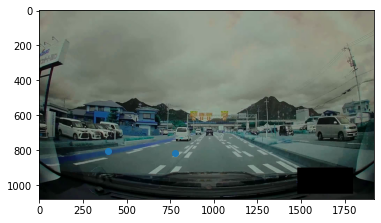

In [ ]:
cap = cv2.VideoCapture(train_path+"scene_00.mp4")
ret, frame = cap.read()
plt.imshow(frame)
plt.scatter([0.20625*w,0.4046875*w],[0.7481481481481481*h,0.7574074074074074*h])
plt.show()
cap.release()

# 転移学習

In [11]:
!git clone https://github.com/ultralytics/yolov5
%cd /content/yolov5/
!pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15123, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 15123 (delta 42), reused 33 (delta 12), pack-reused 15045
Receiving objects: 100% (15123/15123), 14.19 MiB | 26.61 MiB/s, done.
Resolving deltas: 100% (10359/10359), done.
/content/yolov5


In [ ]:
!python detect.py --source /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/yolo_data/images/scene_00_0.jpg --weights yolov5s.pt --conf 0.3 --name demo --exist-ok

detect: weights=['yolov5s.pt'], source=/content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/yolo_data/images/scene_00_0.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=demo, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-97-gfa4bdbe Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

100% 14.1M/14.1M [00:00<00:00, 122MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/yolo_data/images/scene_00_0.jpg: 640x640 6 cars, 1 bus, 3 trucks, 1 kite, 13.7ms
Speed: 0.8ms pre-process, 13.7ms inference, 37.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/demo


In [25]:
%cd /content/yolov5/

/content/yolov5


In [ ]:
!python train.py --img 1280 --batch 16 --epochs 30 --data /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/custom.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/custom.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-97-gfa4bdbe Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0,

In [ ]:
!zip -r weights.zip  runs/train/exp/weights
from google.colab import files
files.download("/content/yolov5/weights.zip")

In [ ]:
# tensorboardの表示
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
!python train.py --img 1280 --batch 16 --epochs 5 --data /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/custom.yaml --weights runs/train/exp/weights/last.pt
!zip -r weights.zip  runs/train/exp/weights
from google.colab import files
files.download("/content/yolov5/weights.zip")
# tensorboardの表示
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
!python train.py --img 1280 --batch 16 --epochs 5 --data /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/custom.yaml --weights runs/train/exp/weights/last.pt
!zip -r weights.zip  runs/train/exp/weights
from google.colab import files
files.download("/content/yolov5/weights.zip")
# tensorboardの表示
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
!python train.py --img 1280 --batch 16 --epochs 5 --data /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/custom.yaml --weights runs/train/exp/weights/last.pt
!zip -r weights.zip  runs/train/exp/weights
from google.colab import files
files.download("/content/yolov5/weights.zip")
# tensorboardの表示
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
!python train.py --img 1280 --batch 16 --epochs 5 --data /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/custom.yaml --weights runs/train/exp/weights/last.pt
!zip -r weights.zip  runs/train/exp/weights
from google.colab import files
files.download("/content/yolov5/weights.zip")
# tensorboardの表示
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
!python train.py --img 1280 --batch 16 --epochs 5 --data /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/custom.yaml --weights runs/train/exp/weights/last.pt
!zip -r weights.zip  runs/train/exp/weights
from google.colab import files
files.download("/content/yolov5/weights.zip")
# tensorboardの表示
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
!python train.py --img 1280 --batch 16 --epochs 5 --data /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/custom.yaml --weights runs/train/exp/weights/last.pt
!zip -r weights.zip  runs/train/exp/weights
from google.colab import files
files.download("/content/yolov5/weights.zip")
# tensorboardの表示
%load_ext tensorboard
%tensorboard --logdir runs

## yolov7

In [ ]:
!python /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/test.py --data /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/custom.yaml --img 1280 --batch 32 --conf 0.001 --iou 0.65 --device 0 --weights /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/yolov7-e6e.pt --name yolov7_640_val

In [ ]:
!python /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/train_aux.py --workers 2 --device 0 --batch-size 16 --data /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/custom.yaml --img 1280 1280 --cfg /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/cfg/training/yolov7-w6-custom.yaml --weights '/content/drive/MyDrive/signate/ワールドＡＩ/yolov7/yolov7-e6e.pt' --name yolov7-w6-custom --hyp /content/drive/MyDrive/signate/ワールドＡＩ/yolov7/data/hyp.scratch.custom.yaml

Traceback (most recent call last):
  File "/usr/lib/python3.8/posixpath.py", line 177, in lexists
    os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: './drive/MyDrive/Cakewalk/Cakewalk Content/Cakewalk Core/PTN MIDI Patterns/Bass/Electric Riffs/content'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/drive/MyDrive/signate/ワールドＡＩ/yolov7/train_aux.py", line 583, in <module>
    opt.data, opt.cfg, opt.hyp = check_file(opt.data), check_file(opt.cfg), check_file(opt.hyp)  # check files
  File "/content/drive/MyDrive/signate/ワールドＡＩ/yolov7/utils/general.py", line 150, in check_file
    files = glob.glob('./**/' + file, recursive=True)  # find file
  File "/usr/lib/python3.8/glob.py", line 21, in glob
    return list(iglob(pathname, recursive=recursive))
  File "/usr/lib/python3.8/glob.py", line 73, in _iglob
    for dirname in dirs:
  File "/usr/lib/python3.8/glob.py", line 73, in _iglob
    for d